This notebook will calculate a paleointensity estimate for a sample by modelling its behaviour during CRM acqusition using a FORC diagram, and when combined with the AF demagnetization spectras of NRM and SIRM this will provide an estimate which will be automatically saved. 

The Cell below imports the functions and packages needed for Preisach CRM palaeointensity method to run

In [1]:
import functions as pf
import time
import threading

 The cell below will ask you for the name of the sample to test and search within the current directory for the FORC data (samplename.frc) file, the NRM AF demagnetisation data (samplename.nrm) and the the SIRM AF demagnetisation data (samplename.sirm) files. AF demagnetsation data should be in generic Magic format. 
 
 In this section you will be asked for an expected field intensity range, the growth rate in m/s during CRM acquisition and the Curie temperature of the main magnetic carrier. 
 
 You will also be shown the zdjerveld plot for the data and be asked to input the AF step where the primary magnetisation component begins, you can zoom in on the plot to help with this. If you canot identify the primary componant with the three projections included we suggest you use a more suitable program to determine the AF step. 


Please enter the sample name: M1
Sample to test: M1
Attempt 1 of running sample M1
The standard field bounds are 40 μT to 60 μT, if you want to keep these enter K, else enter any other charactor:K
Input the natural growth rate in hours:1E-13
Input Curie temperature in °C:350


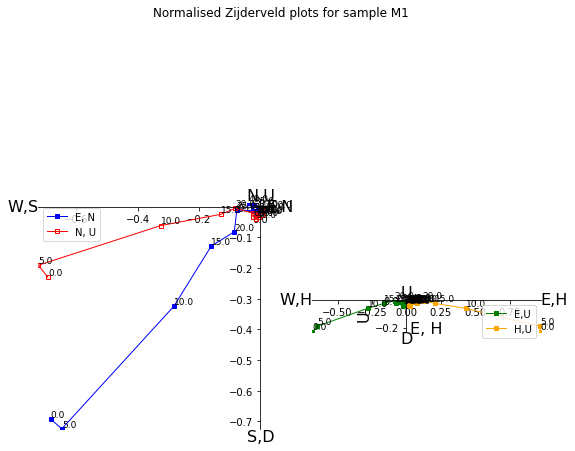

Would you like to zoom in the zplot to make your decison (you can do this multiple times)? (Y or N)N
Pick the AF demag step where the primary componant is identified:5
Selected AF step: 5


In [2]:
if ('X' in locals()) == False:
    X = {}
V = {}
X = pf.find_files2(X)
X = pf.demag_data_generic2(X)
X = pf.proccess_all(X)
X = pf.prod_FORCs(X)
X = pf.plot_zplot(X)

#plot for example 

#list of hc and hi 
#2 different hc values and small hi
hctest = 10.
hctest = 50.
hitest = 1.
hitest = 1.

This cell will calcualte the full width at half maximum to determine the FORC distribution at smoothing factor zero for the model. It will ask you to check there are no noisy FORC diagrams giving unreaslitic FWHMs - if a point on th ebet fit graph lies ar from the line of best fit, remove it. The right hand plot should be a straight line with a slight positive gradient. You can remove anamolous plots, and select the smallest SF which gives reliable data and this will be plotted below.  

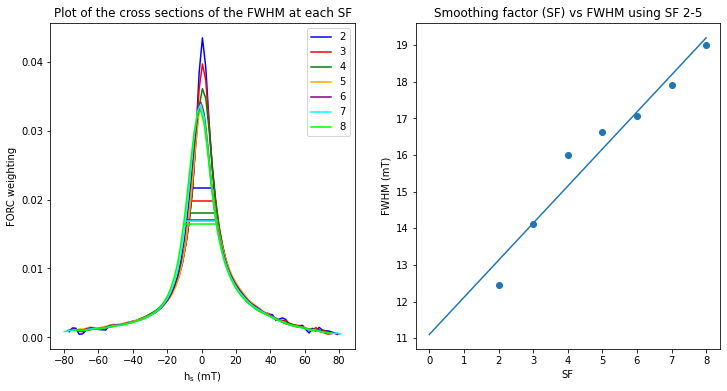

1st attempt 0.011104226965160615 [0.012441683366269624, 0.01410969423727744, 0.016008323191892663, 0.016620007457810455, 0.01705367484159795, 0.017911510489452522, 0.019003777185133894]
1st [0.012441683366269624, 0.01410969423727744, 0.016008323191892663, 0.016620007457810455, 0.01705367484159795, 0.017911510489452522, 0.019003777185133894] 8
Are any of the FWHM unreliable? Enter Y or N: Y
Which SF is unrealiable and needs to be removed?:2
pick 2
Are any other FWHM unreliable? Enter yes or no: N
N
redoing the calcualtion
looking for che ['che', 0.01410969423727744, 0.016008323191892663, 0.016620007457810455, 0.01705367484159795, 0.017911510489452522, 0.019003777185133894]
removed the nan and che [0.01410969 0.01600832 0.01662001 0.01705367 0.01791151 0.01900378]
redoing calcualtion the results 0.011973782412338306
new fwhmlist [0.013723133498952555, 0.01410969423727744, 0.016008323191892663, 0.016620007457810455, 0.01705367484159795, 0.017911510489452522, 0.019003777185133894]
[0.01372

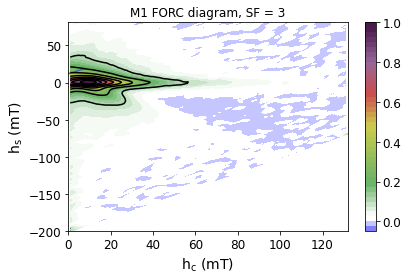

Do you want to change the maximum hc and/or hi value from max hc = 120.0 and max hi = 70.0 from thr FORC file? (Y or N)Y
Set maximum hc (mT) using the above FORC diagram, if unchanged enter 0:100
Set absolute maximum hi (mT) using the above FORC diagram, if unchanged enter 0:75
Enter Y or N
FORC limits: Max hc = 100.0, max hi = 75.0


In [3]:
X = pf.find_plot_fwhm(X)
X = pf.check_fwhm(X) 
X = pf.pick_SF(X)
X = pf.divide_mu0(X) 
X = pf.sym_norm_forcs(X)
pf.norm_rho_all(X) #keep as was  
pf.plot_sample_FORC(X['Hc'], X['Hu'], X['rho_n'], X['SF'], X['name'])
X = pf.user_input(X)

In [4]:
from numba import jit
import numpy as np
from math import acos, pi, degrees, sin, cos, sqrt, log, tanh, ceil
import copy as copy
import matplotlib.pyplot as plt

mu0 = 4*pi*1e-7
ms0 = 270000.0 #491880.5
kb = 1.3806503e-23
tau = 10e-9
roottwohffield = 2**(0.5)  
eul = 1.78107 #exp(eulers const)

In [5]:
#CRM acquisition and function in here 

def CRM_acq(X, V):
    
    SF = X['SF']
    #print('SF', SF)
    curie_t = X['curie_t']
    V['curie_t'] = curie_t
          
    mu0 = 4.*pi*1e-7
    kb = 1.3806503e-23
    tau = 10e-9
    roottwohffield = 2**(0.5)  

    afone = 1
    afzero = 0
    num_hyss =  1000 #300000 #200000 #600000
    V['num_hyss'] = num_hyss

    tempmax = float(X['curie_t'] + 273)
    tempmin=300 
    V['tempmin'] = tempmin
    V['tempmax'] = tempmax
    tempstep=1
    #for each field
    #print('here1')
    #arrays whole thing
    V['cntfield'] = len(X['af_step'])
    cntfield = V['cntfield']
    V['sirm'] = np.zeros((9, cntfield)) #if sirm is global it should be updated and used in function ok
    V['afmag'] = np.zeros((9, cntfield)) #is this the same cntfield size
    V['arm'] = np.zeros((9, cntfield)) #if sirm is global it should be updated and used in function ok
    V['af_step'] = np.copy(X['af_step'])



    V['crm_a'] = np.zeros((9, 9000))
    V['time_a'] = np.zeros((9, 9000))
    #track field used
    fields = np.zeros(10)    

    field = (X['min_field']*1E-6)/mu0
    fieldmax = (X['max_field']*1E-6)/mu0
    fieldstep = (fieldmax-field)/3.
    fields_list_muT = np.array([25., 50., 100., 150.])
    field_arr = (fields_list_muT*1E-6)/mu0
    ct = 0
    #arm_acq_steps_list = np.array([3001, 101])

    for ct in range(len(field_arr)): #(field < (fieldmax)): 
        #print('inside field loop')
        field = field_arr[ct]
        #set CRM field and v quick CRM acquistion
        
        #print('field start CRM acq', field)
        #arm_acq_step = arm_acq_steps_list[count_no]
        num_hyss = 60000 #300000 #hysteron_list[count_no]
        V['num_hyss'] = num_hyss       
        print('number hys', num_hyss) 
        #print('arm_acq_number_steps', arm_acq_step)
        blockper = 0.0
        V['blockper'] = blockper
        hcstore = np.zeros(num_hyss)
        V['hcstore'] = hcstore
        histore = np.zeros(num_hyss)
        V['histore'] = histore
        V['totalm'] = 0
        V['afstore'] = 0. #when TRM acq

        i=0 
        temp=300
        tempt=300
    
        tm = 0.2 
        V['tm'] = tm
        V['beta'] = (1-((temp-273)/(float(curie_t))))**0.43 #MATCH TO INPUTTED CURIE T
        V['ms'] = ms0*V['beta']
        ms = V['ms']
        hys1, num_pop = pf.pop_hys(num_hyss, X, V, SF)   
        #print('pop hys')



        
        ifield = ct
        g = X['growth_rate']

        blockg = np.zeros(num_hyss) 
        boltz = np.zeros(num_hyss)
        blocktemp = np.zeros(num_hyss) 
        temp = 300.
        V['blocktemp'] = blocktemp
        V['boltz'] = boltz
        V['blockg'] = blockg
        V['totalm'] = 0

        V['temp'] = temp

        rate = 1.
        t = 0
        V['rate'] = rate


        i=0 
        temp=300
        tm = 0.2 
        V['tm'] = tm

        afswitch = afzero

        V['hys'] = copy.deepcopy(hys1)


        V = pf.blocked_hys(V)

              

        hys = V['hys']
        #print('ms', ms)
        Ro = 1E-9 #nucleation radius - same for all particles 
        prop = np.zeros((num_hyss,12))
        prop[:,9] = ms*mu0*hys[:,9] #eo for constant de/dv but unsure about hk being constant lose mu0
        prop[:,0] = hys[:,10] #Vf
        prop[:,1] = (3.*prop[:,0]/(4.*pi))**(1./3.) #Rf (radius from forc arond 40 nm)
        final_R = prop[:,1]
        prop[:,2] = (prop[:,1] - Ro)/g #growth time in seconds
        maxt = np.max(prop[:,2]) #max growth time 
        #end growth time for each 
        #prop[:,3] = (maxt- prop[:,2]) #nucleation time for each 

        V['prop'] = prop
        V['totalvol'] = sum(prop[:,0])
        
        tm = 0

        V['tm'] = tm
        track = 0

        #CRM acquition

        t = 0
        tstep = maxt/8000. #chane from 0.5 (change back )
        V['tstep'] = tstep

        tot_time_steps = (np.max(prop[:,2])+0.5*tstep)/tstep
        tot_time_steps = ceil(tot_time_steps)

        tm = 0

        V['aftotalm'] = 0
        V['tm'] = tm #to use for af demag bit delcare here
        x=0 #loop over time steps
        #print('field', field)
        #temperature for CRM acquisition
        temp  = 300. #350. + 273. 
        V['temp'] = 300. #350. + 273. 
        V['beta'] = (1-((temp-273)/(float(curie_t))))**0.43 #MATCH TO INPUTTED CURIE T
        while (t < (np.max(prop[:,2]))): #big main model for 1 field #remove  + 0.5*tstep 
            #print('crm acq')
            #find volumes

            prop = find_tm(prop, num_hyss, t, g, Ro, eul, tau, tstep)
            #print('here2')
            V['track'] = x
            V['prop'] = prop
            blockfind_SC(t, field, afzero, V, X)
            #print('field during CRM acq', field)
            #print(t, field, afzero, V, X)
            #print('here6')
            #print('blockper', V['blockper'])
            V['crm_a'][ifield,x] = V['totalm'] # /total_vol_step
            V['time_a'][ifield,x] = t

            x+=1
            
            #if (t <= (0.4*np.max(prop[:,2]) + 0.5*tstep)):
            #    t+= 120*tstep
            #else:
            t+= tstep #time steps of 2 hours - run about 6 times

        t = t - tstep

        rate = 0
        V['rate'] = rate
        tm = 60
        V['tm'] = tm
        temp = 300.
        beta = (1-(temp-273)/(float(curie_t)))**0.43
        V['beta'] = beta
        fieldzero = 0.0

        #print(t, )

        #cool it down to room temperature and measure the CRM 
        #first approx nothing else block so just times by the new Ms 
        
        blockfind_SC(t, fieldzero, afzero, V, X) #check if totalm, spcounti work still

        #plot CRM acquisition
        plt.scatter((V['time_a'][ifield,:x]/(60.*60)), V['crm_a'][ifield,:x])
        plt.xlabel('time in hours')
        plt.ylabel('crm no units')
        plt.title('CRM acquisition for field = {} muT'.format((field*mu0)*1E6))
        plt.savefig('CRM_acq_field_{}.png'.format(ifield))
        plt.close()
        track+=1
       
        #AF demag

        #calc AF demag of CRM at 273 fK
        V['afmag'][ct, 0] = V['totalm'] #/(sum(hys[:,10]))#/num_hyss #set value here #afmag is 2 thing? and check right totalm
        for i in range(cntfield): #try 1,cntfield
            V['afstore'] = V['af_step'][i]
            blockfind_SC(t, fieldzero, afone, V, X) #unsure about aftotalm - output
            
            #print('CRM demag', V['totalm'])
            V['afmag'][ct, i] = V['totalm'] #*4. #/(sum(hys[:,10]))#/num_hyss #af mag for each field and cnt step - 3 lines of total m for af demag
            #print('CRM', V['totalm']) #*4.)
        track2 = 0
        temp = 300.1



        #ARM acquisitin 300 K after NRM demag

        tm = 60.0 
        prop[:,10] = 60.0 #lab timescales for ARM
        V['prop'] = prop        
        #all blocked at the start but should unblock all first with big AF field
        V['arm_steps'] = np.linspace(100,0,101)
        #V['blocktemp'] = np.ones(num_hyss) #is it all saturation before ARM acqusiton - no there is no magnetisation
        #V['boltz'] = np.ones(num_hyss)
        #V['blockg'] = np.ones(num_hyss)
        V['arm_blocked'] = np.zeros((num_hyss)) #treat asif none blocked
        #V['blockper'] = 1. # start with non blocked

        #ARM acquisition simulate smooth decrease in intensity with 100 - 0 mT AF field in 1 mT steps, once blocked say blocked ?
        #expect result to be same as if do 100 mT and 0 mT

        

        V['afstore'] = 100. #V['arm_steps'][0] #AF field used for ARM acquisition
        blockfind_SC_arm(t, fieldzero, afone, V, X)
        V['arm'][ifield,i]
        #initial ARM array for demag, same size as SIRM and afmag



        for i in range(len(V['arm_steps'])):
            V['afstore'] = V['arm_steps'][i] #AF field used for ARM acquisition
            blockfind_SC_arm(t, fieldzero, afone, V, X)

            #plt.tricontourf(V['hys'][:,0], V['hys'][:,1], V['boltz'][:], levels=np.linspace(-1.1,1.1,100))
            #plt.colorbar()
            #plt.savefig('contour_final_distribution_{}.png'.format(V['afstore']))
            #plt.close()
            #print('blockper outside function', V['blockper'])
            #current_hi = V['hys'][:,1]*V['blockper']
            #print('original hi', V['hys'][:,1])
            #print('current blockper', V['blockper'])
            #print('current hi', current_hi)

            #if (V['blockper'] > 0.2):
            #    plt.tricontourf(V['hys'][:,0], current_hi[:], V['boltz'][:], levels=np.linspace(-1.1,1.1,100))
            #    plt.colorbar()
            #    plt.savefig('contour_current_distribution_{}.png'.format(V['afstore']))
            #    plt.close()

                #plt.tricontourf(V['hys'][:,0], V['hys'][:,1], V['boltz'][:], levels=np.linspace(-1.1,1.1,100))
                #plt.colorbar()
                #plt.title('Preisach space hc, hi, boltz arm 0 dc acq step {}'.format(V['afstore']))
                #plt.ylabel('hi')
                #plt.xlabel('hc')
                #plt.savefig('preisach_arm_acq_boltz_0dc_{}.png'.format(V['afstore']))
                #plt.close()                

            #print('arm acq', V['totalm'])

        #V['arm'] =  #track totalm dueing ARM acquisition
        tm = 60.0 
        prop[:,10] = 60.0 #lab timescales for ARM
        V['prop'] = prop




        #plt.tricontourf(V['hys'][:,0], V['hys'][:,1], V['boltz'][:], levels=np.linspace(-1.1,1.1,100))
        #plt.colorbar()
        #plt.title('Preisach space hc, hi, boltz arm 0 dc acq step {}'.format(V['afstore']))
        #plt.ylabel('hi')
        #plt.xlabel('hc')
        #plt.savefig('preisach_arm_acq_boltz_0dc_{}.png'.format(V['num_hyss']))
        #plt.close()           
        #acquire ARM
        #V['afstore'] = 100. #AF field used for ARM acquisition
        #blockfind_SC_arm(t, fieldzero, afone, V, X)

        #V['afstore'] = 0. #AF field used for ARM acquisition
        #blockfind_SC_arm(t, fieldzero, afone, V, X)

        #V['arm_track'] = np.zeros(len(V['arm_steps']))
        V['arm'][ifield,0] = V['totalm']  #just running once, same idea as afmagstore ?? 
        print('arm', V['totalm'])

        #AF demag ARM

        for i in range(cntfield): 
            afstore = V['af_step'][i]
            V['afstore'] = afstore            
            blockfind_SC(t, fieldzero, afone, V, X) #af demag arm as normal like did for afmag and sirm
            V['arm'][ifield,i] = V['totalm'] #*4. #rewrite the first point?
            #print('arm demag', V['arm'][ifield,i])

            #plt.tricontourf(V['hys'][:,0], V['hys'][:,1], V['boltz'][:], levels=np.linspace(-1.1,1.1,100))
            #plt.colorbar()
            #plt.title('Preisach space hc, hi, boltz arm (0 dc) demag step {}'.format(V['afstore']))
            #plt.ylabel('hi')
            #plt.xlabel('hc')
            #plt.savefig('preisach_arm_demag_boltz_0dc_{}.png'.format(V['afstore']))
            #plt.close()



        V['arm_mag']= V['arm']
        #print('ams', field, V['arm'][ifield,0])        
        #print('nrm',V['afmag'][ct, 0])

        #calc SIRM at 300 K
        blockg = np.ones(num_hyss)
        boltz = np.ones(num_hyss)
        blocktemp = np.ones(num_hyss) 
        V['blocktemp'] = blocktemp
        V['boltz'] = boltz
        V['blockg'] = blockg
        #print('blockg match one above', V['blockg'])
        fieldzero = 0.0
        #aftotalm referred to as sir
        V['afstore'] = 0. #for first value

        blockfind_SC(t, fieldzero, afone, V, X)
        


        
        V['sirm'][ifield,0] = V['totalm'] #just running once, same idea as afmagstore ?? 


        for i in range(cntfield): 
            afstore = V['af_step'][i]
            V['afstore'] = afstore

            blockfind_SC(t, fieldzero, afone, V, X)
            V['sirm'][ifield,i] = V['totalm'] #rewrite the first point?


        #impart ARM aswell 
        #V['arm'] =  #track totalm dueing ARM acquisition

        fields[ct] = field
        #field = field + fieldstep 

    
        #negs = 0.0 #negative sirm??
        
        #negsirm[ct] = -negs

        #V['aconst'] = aconst
        #V['afmag'] = afmag
        #V['sirm'] = sirm #use to plot rom dictionary
        #V['ifield'] = ifield
        V['fields'] = fields
   
        ifield = ifield +1 
        #V['aconst'] = aconst

        V['ifield'] = ifield
        #V['fields'] = fields
        #V['track'] = track
        #V['track2'] = track2        
       
        ct +=1
    return X,V

In [6]:
def blockfind_SC(t, field, afswitch, V, X): #try removing counttime as input/output

    hys = V['hys']
    prop = V['prop']
   
    max_total_m_a = hys[:,10]*hys[:,3]
    max_total = sum(max_total_m_a)
	
    vol_rem = V['vol_rem']
	
    num_hyss = V['num_hyss']

    histore = V['histore']
    beta = V['beta']
    rate = V['rate']

    tm = V['tm'] #try setting this for use in AF demag
    tstep = V['tstep']
    
    temp = V['temp']
    #temp = tempmin + tempstep
   
    hfstore = np.zeros(num_hyss)


    blockper = V['blockper'] 

    blocktemp = V['blocktemp'] 
    boltz = V['boltz']
    blockg = V['blockg']

    #end_mag = V['end_mag']

    totalm = V['totalm']
    afstore = V['afstore']


    #max_total = np.sum(hys[:,3]) # sum of FORC distributions 
    var_1 = np.array((num_hyss, beta, blockper, temp, t, tstep, rate, field, tm))

    hfstore, histore, boltz, blocktemp = block_loc_C(var_1, hys, prop, blockg, boltz)
  
    blockper, totalm, boltz, blockg = block_val_C(hys, prop, histore, hfstore, blocktemp, beta, num_hyss, boltz, blockg, field, afswitch, afstore, max_total, vol_rem, t, tstep)
 
    V['aftotalm'] = totalm
    V['sir'] = totalm

    V['blockper'] = blockper
    V['blocktemp'] = blocktemp
    V['boltz'] = boltz
    V['blockg'] = blockg
    V['totalm'] = totalm

    V['tm'] = tm

    return #totalm

#CRM acquisition functions
#CRM acquisition and AF demag 
@jit(nopython = True)
def block_loc_C(var_1, hys, prop, blockg, boltz):
     #unpack variables from input array
    #unpack var_1
    num_hyss = int(var_1[0])
    beta = float(var_1[1])
    blockper = float(var_1[2])
    temp = float(var_1[3])
    t = float(var_1[4])
    tstep = float(var_1[5])
    rate = float(var_1[6])    
    field = float(var_1[7])
    tm = float(var_1[8])


    tau = 10e-9
 
    roottwohffield = 2**(0.5)
    hfstore = np.zeros((num_hyss))
    histore = np.zeros((num_hyss))    
    hcstore = np.zeros((num_hyss))   
    blocktemp = np.zeros((num_hyss))
    i=0 
    for i in range(num_hyss): #dynamic contributions - to hc dormann 1988 used?
        if (t >= 0.):

            phitemp=((sin(hys[i,5])**(2./3.))+(cos(hys[i,5])**(2./3.)))**(-3./2.) #phitemp from hys[5] -> phi               
            hc=(sqrt(2))*(hys[i,9]*beta) #test and time HCbysqrt2 to get hc and matfhes similar order mag to hys[i,0/mu0 -> hc in same units using in hk - seems correct]
            
            hcstore[i] = hc/(sqrt(2.)) #different to hys[0]
        
            
            hi = hys[i,1]*beta*blockper #divide here by mu0
            
    
            histore[i] = hi/(sqrt(2.)) #should all be zero, without blockper, all look milar to hys[1,0] in mg

            g_ang=0.86+1.14*phitemp
            #print(hys[i,9], beta)
            h_hs = field - histore[i]
            v_co = (1 - ((abs(h_hs))/(hys[i,9]*beta)))
            if (v_co <= 0):
                v_co = 0.00001               
            
            v_act_c = prop[i,5]*v_co

            hf = hys[i,11]*(1/(v_act_c))
        
            hfstore[i] = hf #values at expected as hc/mu0

            if (rate == 1): #rate first set to 1 so shold do this
                
                tm= prop[i,10]
                
                if (tm == 0.0): #unsure
                    tm = 60.0
    
            #print('tm', tm)
            
            #if (end_mag == 1.0):
            #    tm = 60.0
            ht = (roottwohffield)*hf*(log(tm/tau)) #new tm 
        
            
            bracket = 1-(2*ht*phitemp/hc)**(1/g_ang)
            
            hiflipplus = hc*bracket+field*(roottwohffield) # using hs=-hi then field is +ve not -ve, 
    
            hiflipminus=-hc*bracket+field*(roottwohffield) #see which way fields flips
            trialtemp=0

            if (hc >= (2*ht*phitemp)): #still loop over each hys, +1

                if ((hi > hiflipminus) and (hi < hiflipplus)): #+2 blocked

                    if (blockg[i] == 0) or (blockg[i] == 2) or (blockg[i] == -2): #+3 prev blocked until this point
                        
                        if (hi >= (field*roottwohffield)): #+4
                            
                            blocktemp[i] = -1
                            
                        else:
                            #print('blockg = 0,2,-2 and hi < field*rootwo', 'blockg', blockg[i], 'hi', hi, 'field*roottwo', field*roottwohffield)
                            blocktemp[i] = 1 #end +3 unsure if sholud ended both or just one
                            
                    elif (blockg[i] == -1): #this line, already block stay , not need
                        
                        blocktemp[i] = -1
                

                    elif (blockg[i] == 1):
                        blocktemp[i] = 1

                elif (hi >= hiflipplus):#else field blocking above ht, this is hi test hiflip etc
                    # if ( abs(blockg[i]) != 1) and (rate == 1): #this occurs if blocked a hysteron during cooling
                    blocktemp[i] = -2
                
                    
                else:
                    blocktemp[i] = 2

            else: #hc < 2*ht*phitemp. this is correctm meaning else above isnt

        
                if ((hi < hiflipminus) and (hi > hiflipplus)): 
                    blocktemp[i] = 0
                else: #field blocking - below hc
                    if (hi >= hiflipminus):
                        blocktemp[i] = -2

                    else:

                        blocktemp[i] = 2

            if (temp < trialtemp):
                #need print to screen
                print('blocktemp', blocktemp[i])
                
    return hfstore, histore, boltz, blocktemp

@jit(nopython = True)
def find_tm(prop, num_hyss, t, g, Ro, eul, tau, tstep):  
    l=0
    for l in range(int(num_hyss)): #just do for half points  - (prop[i,2] + (0.5*tstep))

        if (t <= prop[l,2]): #time grater than nucleation time, less than final growth time
            prop[l,4] = Ro + g*(t) #current radius

            prop[l,11] = prop[l,5] #prev volume before change it
            prop[l,5] = ((4*pi)/3.)*(prop[l,4])**3  #volume current
            Vdot = (4*pi*g*(prop[l,4])**2) #rate volume growth
            prop[l,10] = ((eul*prop[l,5])/Vdot)/(log((eul*prop[l,5])/(tau*Vdot))) # use Vdot here and overwrite for next time
            #if ( l < 1):
            #    print(t, prop[l,2], 'less', prop[l,5])
        else:

            prop[l,4] = Ro + g*(prop[l,2]) #current radius
            prop[l,11] = prop[l,5] #prev volume before change it
            prop[l,5] = ((4*pi)/3.)*(prop[l,4])**3  #volume current
            Vdot = (4*pi*g*(prop[l,4])**2) #rate volume growth
            prop[l,10] = ((eul*prop[l,5])/Vdot)/(log((eul*prop[l,5])/(tau*Vdot))) # use Vdot here and overwrite for next time
            #if ( l < 1):
            #    print(t, prop[l,2], 'more', prop[l,5])            
            
            #stay the same 
        l+=1
    return prop



@jit(nopython = True)
def block_val_C(hys, prop, histore, hfstore, blocktemp, beta, num_hyss, boltz, blockg, field, afswitch, afstore, max_total, vol_rem, t, tstep):

    totalm = 0.0
    totalmoment = 0

    i=0
    num_blocking = 0
    blockper = 0.
    #print('field ofr CRM acq inside', field)
    for i in range(num_hyss):

        
        blockg[i] = blocktemp[i]
        absblockg = abs(blockg[i])
        if (t >=0):
           
            if (absblockg == 1): #if blockg 1 or -1
                if (boltz[i] < 0.00000001) and (boltz[i] > -0.000000001): #only zero
                    #print('setting boltz as its 0 (check)', boltz[i])
                    boltz[i] = tanh((field - histore[i])/hfstore[i])
                    #print('boltz', boltz[i])
                    if (afswitch == 0):
                        num_blocking+=1
                    if (afswitch == 1):
                   # print('inside tanh reset during af demag', (((50E-6/mu0) - histore[i])/hfstore[i]))
                        boltz[i] = 0.

            if (blockg[i] == -2):
                #print('blockg = -2')
                moment = 0 #changed from zero to minues zero
                #boltz[i] = -1
            elif (blockg[i] == 2):
                #print('blockg = +2')
                moment = 0
                #boltz[i] = 1 #but need to overwrite this
            else:

                moment = blockg[i] #where does moment come from? - set to blockg if blockg not equal to 1


            
            
            if (afswitch == 1): #afswtich given in function, 1 or 0
               # afstore =  CT['afstore'] # move where relevant as no values unti demag - poss give dummy name to keep with rest of unpack of V
                #break
                #print('should not see this message, afswtich wrong')
                hi = histore[i]*(sqrt(2))

                #hys9 change due to field?
                #hc is just hk and not hf 

                hc = (sqrt(2))*(hys[i,9]*beta)*(((sin(hys[i,6])**(2./3.))+(cos(hys[i,6])**(2./3.)))**(-3./2.))
        
                af = afstore/(1000*mu0) #define later. afstore number
                if (hi >= 0) and (hi > (hc-af)): #whats this bit mean
                    moment = 0
                    blockg[i] = -2

                    boltz[i] = 0.
                if (hi <= 0) and (hi < (-hc + af)):
                    moment = 0
                    blockg[i] = 2

                    boltz[i] = 0.0
            #totalm = totalm + (abs(moment)*abs(cos(hys[i,5]))*beta*(boltz[i])*((hys[i,3]*prop[i,5])/max_total)) #add in forcdist (hys[i,3])
            totalm = totalm + (abs(moment)*abs(cos(hys[i,5]))*beta*(boltz[i])*((hys[i,3]*prop[i,5])/max_total)) 
            #totalm = totalm + (abs(moment)*abs(cos(hys[i,5]))*beta*(boltz[i])*((prop[i,5])/(max_total)))
            #once done totalm return field blocked hys boltz to zero so can reblock 
            if (blockg[i] == -1) or (blockg[i] == 1):
                moment_block = 1
            else:
                moment_block = 0
		
            blockper=blockper+ (abs(moment_block))*hys[i,3]*prop[i,5]
            totalmoment=totalmoment+moment

        

    if (blockper != 0.):
        blockper= (blockper)/(vol_rem)
    else:
        #blockper = 0.
        blockper = 1E-15
    #print(num_blocking)
    return blockper, totalm, boltz, blockg

In [7]:
#ARM blockfind function

def blockfind_SC_arm(t, field, afswitch, V, X): #try removing counttime as input/output

    hys = V['hys']
    prop = V['prop']
   
    max_total_m_a = hys[:,10]*hys[:,3]
    max_total = sum(max_total_m_a)
	
    vol_rem = V['vol_rem']
	
    num_hyss = V['num_hyss']

    histore = V['histore']
    beta = V['beta']
    rate = V['rate']

    tm = V['tm'] #try setting this for use in AF demag
    tstep = V['tstep']
    
    temp = V['temp']
    #temp = tempmin + tempstep
   
    hfstore = np.zeros(num_hyss)


    blockper = V['blockper'] 

    blocktemp = V['blocktemp'] 
    boltz = V['boltz']
    blockg = V['blockg']

    #end_mag = V['end_mag']

    totalm = V['totalm']
    afstore = V['afstore']
    arm_blocked = V['arm_blocked']

    af_field = V['afstore']
    #print(af_field)


    var_1 = np.array((num_hyss, beta, blockper, temp, t, tstep, rate, field, tm))
    #print('var_1', var_1)
    hfstore, histore, boltz, blocktemp = block_loc_C_arm(var_1, hys, prop, blockg, boltz, af_field)
  
    blockper, totalm, boltz, blockg, arm_blocked = block_val_C_arm(hys, prop, histore, hfstore, blocktemp, beta, num_hyss, boltz, blockg, field, afswitch, afstore, max_total, vol_rem, t, tstep, arm_blocked, blockper)
 
    V['aftotalm'] = totalm
    V['sir'] = totalm

    V['blockper'] = blockper
    V['blocktemp'] = blocktemp
    V['boltz'] = boltz
    V['blockg'] = blockg
    V['totalm'] = totalm
    V['arm_blocked'] = arm_blocked
    V['tm'] = tm

    return #totalm

#CRM acquisition functions
#CRM acquisition and AF demag 
@jit(nopython = True)
def block_loc_C_arm(var_1, hys, prop, blockg, boltz, af_field):
     #unpack variables from input array
    #unpack var_1
    num_hyss = int(var_1[0])
    beta = float(var_1[1])
    blockper = float(var_1[2])
    temp = float(var_1[3])
    t = float(var_1[4])
    tstep = float(var_1[5])
    rate = float(var_1[6])    
    field = float(var_1[7])
    tm = float(var_1[8])
    #print('blockper for calc histore in ARM', blockper)

    tau = 1e-9
 
    roottwohffield = 2**(0.5)
    hfstore = np.zeros((num_hyss))
    histore = np.zeros((num_hyss))    
    hcstore = np.zeros((num_hyss))   
    blocktemp = np.zeros((num_hyss))
    i=0 
    for i in range(num_hyss): #dynamic contributions - to hc dormann 1988 used?
        if (t >= 0):

            phitemp=((sin(hys[i,6])**(2./3.))+(cos(hys[i,6])**(2./3.)))**(-3./2.) #phitemp from hys[5] -> phi               
            hc=(sqrt(2))*(hys[i,9]*beta) #test and time HCbysqrt2 to get hc and matfhes similar order mag to hys[i,0/mu0 -> hc in same units using in hk - seems correct]
            
            hcstore[i] = hc/(sqrt(2.)) #different to hys[0]
        
            
            hi = hys[i,1]*beta*blockper #divide here by mu0
            
    
            histore[i] = hi/(sqrt(2.)) #should all be zero, without blockper, all look milar to hys[1,0] in mg

            g_ang=0.86+1.14*phitemp
            #print(hys[i,9], beta
            af_field_cor = (af_field*1E-6)/mu0 # 100 mT
            h_hs = af_field_cor - histore[i] #100 applied field 
            v_co = (1 - ((abs(h_hs))/(hys[i,9]*beta)))
            if (v_co <= 0):
                v_co = 0.00001               
            
            v_act_c = prop[i,5]*v_co

            hf = hys[i,11]*(1/(v_act_c))
        
            hfstore[i] = hf #values at expected as hc/mu0
            #this needs to be the correct hf for arm acquisition 

            if (rate == 1): #rate first set to 1 so shold do this
                
                tm= 60. #prop[i,10]
                #60. 
                if (tm == 0.0): #unsure
                    tm = 60.0
    
            #print('tm', tm)
            
            #if (end_mag == 1.0):
            #    tm = 60.0
            ht = (roottwohffield)*hf*(log(tm/tau)) #new tm 
        
            
            bracket = 1-(2*ht*phitemp/hc)**(1/g_ang)
            
            hiflipplus = hc*bracket+field*(roottwohffield) # using hs=-hi then field is +ve not -ve, 
    
            hiflipminus=-hc*bracket+field*(roottwohffield) #see which way fields flips
            trialtemp=0

            if (hc >= (2*ht*phitemp)): #still loop over each hys, +1
                
                if ((hi > hiflipminus) and (hi < hiflipplus)): #+2 blocked

                    if (blockg[i] == 0) or (blockg[i] == 2) or (blockg[i] == -2): #+3 prev blocked until this point
                        
                        if (hi >= (field*roottwohffield)): #+4
                            
                            blocktemp[i] = -1
                            
                        else:
                            #print('blockg = 0,2,-2 and hi < field*rootwo', 'blockg', blockg[i], 'hi', hi, 'field*roottwo', field*roottwohffield)
                            blocktemp[i] = 1 #end +3 unsure if sholud ended both or just one
                            
                    elif (blockg[i] == -1): #this line, already block stay , not need
                        
                        blocktemp[i] = -1
                

                    elif (blockg[i] == 1):
                        blocktemp[i] = 1

                elif (hi >= hiflipplus):#else field blocking above ht, this is hi test hiflip etc
                    # if ( abs(blockg[i]) != 1) and (rate == 1): #this occurs if blocked a hysteron during cooling
                    blocktemp[i] = -2
                
                        
                else:
                    blocktemp[i] = 2

            else: #hc < 2*ht*phitemp. this is correctm meaning else above isnt
                #print('SP', hc, 2*ht*phitemp)
        
                if ((hi < hiflipminus) and (hi > hiflipplus)): 
                    blocktemp[i] = 0
                else: #field blocking - below hc
                    if (hi >= hiflipminus):
                        blocktemp[i] = -2

                    else:

                        blocktemp[i] = 2

            if (temp < trialtemp):
                #need print to screen
                print('blocktemp', blocktemp[i])
                
    return hfstore, histore, boltz, blocktemp

@jit(nopython = True)
def block_val_C_arm(hys, prop, histore, hfstore, blocktemp, beta, num_hyss, boltz, blockg, field, afswitch, afstore, max_total, vol_rem, t, tstep, arm_blocked, blockper_current):

    totalm = 0.0
    totalmoment = 0

    i=0
    num_blocking = 0
    blockper = 0.
    #print('blockper current', blockper_current)
    #use old blockper here
    field_block_pos = 0.
    field_block_neg = 0.
    dc_blocked_pos = 0.
    dc_blocked_neg = 0.
    dc = (50.*1E-6)/mu0 #0.05/(1000.*(mu0))
    af = afstore/(1000.*(mu0))
    #print('af field', af)
    #print('dc field used boundaries', dc)
    for i in range(num_hyss):

        
        blockg[i] = blocktemp[i]
        absblockg = abs(blockg[i])
        if (t >= 0):
           
            if (absblockg == 1): #if blockg 1 or -1
                if (boltz[i] < 0.00000001) and (boltz[i] > -0.000000001): #only zero
                    #print('setting boltz as its 0 (check)', boltz[i])
                    boltz[i] = tanh((field - histore[i])/hfstore[i])
                    if (afswitch == 0):
                        num_blocking+=1
                    if (afswitch == 1):
                   # print('inside tanh reset during af demag', (((50E-6/mu0) - histore[i])/hfstore[i]))
                        boltz[i] = 0.

            if (blockg[i] == -2):
                #print('blockg = -2')
                moment = -0 #changed from zero to minues zero
            elif (blockg[i] == 2):
                #print('blockg = +2')
                moment = 0
            else:

                moment = blockg[i] #where does moment come from? - set to blockg if blockg not equal to 1


            
            
            if (afswitch == 1): #afswtich given in function, 1 or 0
                # afstore =  CT['afstore'] # move where relevant as no values unti demag - poss give dummy name to keep with rest of unpack of V
                #break
                #print('should see this message during ARM acq, afswtich 1')
                hi = histore[i]*(sqrt(2))*blockper_current #hi depend on number blocked - occur slowly 
                #print('blockper current', blockper_current)
                #print('blockper', blockper) 
                hc = (sqrt(2))*(hys[i,9]*beta)*(((sin(hys[i,5])**(2./3.))+(cos(hys[i,5])**(2./3.)))**(-3./2.))
                #uses hf
                #what is hf during ARM acquisition 

                af = afstore/(1000.*(mu0)) #define later. afstore number do in 100 mTfield 100 mT, 0.05 mT
                #dc = (50.*1E-6)/mu0 #0.05/(1000.*(mu0))


                
                if (hi > (hc - af + dc)):#  and (hi >= 0): remove need for hi > 0 so it does SP all in 1 step 
                    boltz[i] = 0.
                    arm_blocked[i] = 0. #FB so no blockper contribution
                    moment = -1.
                elif (hi < (-hc + af + dc)): #remove need to be hi less than zero so it does SP too
                    boltz[i] = 0.
                    arm_blocked[i] = 0. #FB so no blockper contribution
                    moment = 1.
                #most should overright 
                elif (hi <= dc) and (boltz[i] == 0.): #if not in these bounds its remanance
                    boltz[i] = 1.
                    arm_blocked[i] = 1.
                    moment = 1. 
                elif (boltz[i] == 0.): #this should be the bit above - which is slightly less
                    boltz[i] = -1.                    
                    arm_blocked[i] = -1.
                    moment = -1.
                else:
                    #everything stay the same
                    boltz[i] = boltz[i]
                    arm_blocked[i] = arm_blocked[i]
                    moment = moment
            #totalm = totalm + (abs(moment)*abs(cos(hys[i,5]))*beta*(boltz[i])*((hys[i,3]*prop[i,5])/max_total)) #add in forcdist (hys[i,3])
            totalm = totalm + (abs(moment)*abs(cos(hys[i,5]))*beta*(boltz[i])*(hys[i,3])) #*prop[i,5])/max_total))
            #totalm = totalm + (abs(moment)*abs(cos(hys[i,5]))*beta*(boltz[i])*hys[i,3]) #*((prop[i,5])/(max_total)))
            #changed angle here to hys[6]
            #each hysteron
            #if (i<3) or (i>9997):
            #    print(i, '\t', hys[i,1], '\t', hi, '\t', blockper_current, '\t', boltz[i], '\t', arm_blocked[i], '\t', (hc-af+dc), '\t', (-hc+af+dc))
            #    print('blockper current', blockper_current)
                #print('blockper', blockper) 
            #if (blockg[i] == -1) or (blockg[i] == 1):
            #blockper come from arm blocked
            if (arm_blocked[i] == -1) or (arm_blocked[i] == 1): #(blockg[i] == -1) or (blockg[i] == 1):
                moment_block = 1
            else:
                moment_block = 0
		
            blockper=blockper+ ((abs(moment_block))*prop[i,5]*hys[i,3]) #*hys[i,10])
            totalmoment=totalmoment+moment

    #just do each step 
    #print('sum armblocked', np.sum(arm_blocked))
    #print('af step', afstore, 'sum boltz', np.sum(boltz[:]))


    
        
    #print('printed all numbers each time')
    #print('af at end of this af step')
    if (blockper != 0.):
        blockper= (blockper)/(vol_rem)
    else:
        #blockper = 0.
        blockper = 1E-15
    #print(num_blocking)
    return blockper, totalm, boltz, blockg, arm_blocked

The next section will model CRM acquistion and use the NRM and ARM data to calculate the paleointensity (This takes ~ 3 minutes)

In [8]:
start = time.time()
thread = pf.ElapsedTimeThread() #removed the print from this - need to add back in
thread.start()
X, V = CRM_acq(X, V)
time.sleep(5)
# something is finished so stop the thread
thread.stop()
thread.join()
print() # empty print() to output a newline
print("Finished in {:.3f} seconds".format(time.time()-start))



number hys 60000
corr 0.8486209701627615


C:\Users\evieb\OneDrive - Imperial College London\PhD\thesis\intensity_chapter\new_intensity_chatper\discussion\diffgrowth\pi_diff_g\re_run_diff_plots\nucleate_same\functions.py:2390: RuntimeWarning: divide by zero encountered in true_divide
  v_act = (kb*tempt)/(hf*mu0*ms)
C:\Users\evieb\OneDrive - Imperial College London\PhD\thesis\intensity_chapter\new_intensity_chatper\discussion\diffgrowth\pi_diff_g\re_run_diff_plots\nucleate_same\functions.py:2446: RuntimeWarning: invalid value encountered in double_scalars
  bracket = 1-(2*ht*phitemp/hc)**(1/g)
C:\Users\evieb\Anaconda3\lib\site-packages\numba\core\dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ModuleNotFoundError(No module named 'numba_scipy')'.
  entrypoints.init_all()


arm 253.45424857688903
number hys 60000
corr 0.8486209701627615


C:\Users\evieb\OneDrive - Imperial College London\PhD\thesis\intensity_chapter\new_intensity_chatper\discussion\diffgrowth\pi_diff_g\re_run_diff_plots\nucleate_same\functions.py:2390: RuntimeWarning: divide by zero encountered in true_divide
  v_act = (kb*tempt)/(hf*mu0*ms)
C:\Users\evieb\OneDrive - Imperial College London\PhD\thesis\intensity_chapter\new_intensity_chatper\discussion\diffgrowth\pi_diff_g\re_run_diff_plots\nucleate_same\functions.py:2446: RuntimeWarning: invalid value encountered in double_scalars
  bracket = 1-(2*ht*phitemp/hc)**(1/g)


arm 261.85933595825213
number hys 60000
corr 0.8486209701627615
arm 264.15764923384
number hys 60000
corr 0.8486209701627615
arm 261.5710086859396

Finished in 1203.433 seconds


In [ ]:
#orthogonal projection 
#code from https://saturncloud.io/blog/how-to-perform-orthogonal-regression-fitting-using-scipy-least-squares-method/
import scipy.optimize as opt

def orthogonal_distance(params, x, y):
    m, b = params
    return (y - (m * x + b)) / np.sqrt(1 + m ** 2)

def orthogonal_regression(x, y):
    initial_guess = [1.0, 1.0]
    params, _ = opt.leastsq(orthogonal_distance, initial_guess, args=(x, y))
    #residuals = orthogonal_distance(params, x, y)
    return params #, residuals

In [9]:
def calc_PI_checks_SIRM(V,X):
    mu0 = 4.*pi*1e-7
    sirm = V['sirm']
    print('sirm', V['sirm'])

    #arm = V['arm']
    #print('arm', arm)
    cntfield = X['cntfield']
    name = X['name']
    ifield = V['ifield']
    demagstep = X['af_step']
    #set first value as v v low just so remove zeros to plot easily
    demagstep2 = demagstep
    demagstep2[0] = 0.0001
    demagstep2 = demagstep2[demagstep2 != 0]
    sirm2 = sirm
    sirmn = np.copy(sirm2) #this is normalising the sirm demag
    for i in range(V['ifield']):
        for j in range(cntfield): #change back to 23 
            sirmn[i][j] = (sirm2[i][j]/(np.mean(sirm2[i][0:3]))) #norm by 3

    af_sirm_n = X['af_sirm']
    norm = np.mean(af_sirm_n[0:3])
    af_sirm_n_n = np.copy(af_sirm_n)
    for i in range(len(af_sirm_n)):
        af_sirm_n_n[i] = af_sirm_n[i]/norm

    V['af_sirm_n_n'] = af_sirm_n_n

    sirm_p = sirmn[:ifield,:cntfield] #change 4 to no fields
    #write to file at some point
    V['sirm_plot'] = sirm_p[2]

    #normalise ARM demag

    #arm2 = arm
    #armn = np.copy(arm2) #this is normalising the sirm demag
    #for i in range(V['ifield']):
    #    for j in range(cntfield): #change back to 23 
    #        armn[i][j] = (arm2[i][j]/(np.mean(arm2[i][0])))

    #af_arm_n = X['af_arm']
    #norm = np.mean(af_arm_n[0])
    #af_arm_n_n = np.copy(af_arm_n)
    #for i in range(len(af_arm_n)):
    #    af_arm_n_n[i] = af_arm_n[i]/norm

    #V['af_arm_n_n'] = af_arm_n_n

    #arm_p = armn[:ifield,:cntfield] #change 4 to no fields
    #write to file at some point
    #V['arm_plot'] = arm_p[2]
    ###################
    afpick = X['af_pick'] #6 #pick from user - Z-plot

    #prepare CRM demag 
    afmag = V['afmag'] #simulated af demag
    afmag2 = afmag
    afmagn = np.copy(afmag2)
    #norm_afmag = afmag2[i][afpick]
    for i in range(V['ifield']):
        for j in range(cntfield): #change back to 23 
            afmagn[i][j] = (afmag2[i][j]/(afmag2[i][afpick])) # norm to max not first 3 

    af_nrm_n = X['af_nrm']
    norm_af = af_nrm_n[afpick]
    af_nrm_n_n = np.copy(af_nrm_n)
    for i in range(len(af_nrm_n_n)):
        af_nrm_n_n[i] = af_nrm_n[i]/norm_af
    
    V['af_nrm_n_n'] = af_nrm_n_n
    V['afmagn'] = afmagn

    #V['af_arm_n_n'] = af_arm_n_n

    #arm_p = armn[:ifield,:cntfield] #change 4 to no fields
    #write to file at some point
    #V['arm_plot'] = arm_p[2]



    #initiate figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,5))
    #w, h = figaspect(1)
    #fig, ax = plt.subplots(figsize=(w,h))
    #ax1.set(aspect=1)
    ax1.plot(demagstep2, sirm_p[2], marker = 'o', color = 'r', label = 'simulated') #x = 22, y = 100 one plotted is largest field? - all same
    ax1.plot(demagstep2, af_sirm_n_n, marker = 'o', color = 'b', label = 'measured')        
    ax1.set_ylim(0,1.3)
    ax1.set_xlim(0,np.nanmax(demagstep2))
    ax1.set_ylabel('SIRM (normalised)')
    ax1.set_xlabel('AF peak (mT)')
    ax1.legend(loc='upper right')
    ax1.set_title('SIRM demagnetization spectra for sample {}'.format(name))
    ax1.grid()

    # get rest ready 
    #afmag = V['afmag'] #simulated af demag
    #measured data
    #af_nrm_n = X['af_nrm'] 
    #af_arm_n = X['af_arm']
    name = X['name']
    fields = V['fields']
    af_step = X['af_step']




    #######################
    sit = ifield

    ys = np.zeros((100))

    cntfieldaf = cntfield

    af_step_list = []
    shortdiv = np.zeros((cntfield))
    shortminus = np.zeros((cntfield))

    res = []
    flat = 0 #set here as well as earlier to save time when testing
    afratio = 0
    #do the shortdiv etc seperate

    for i in range(cntfieldaf): #cntfieldsaf
        #likely remove this -----
        xlist = []
        ylist = []
        sumx = 0.
        sumy = 0.
        sumxy = 0.
        sumxx = 0.
        #print('afmag', afmag)
        #print('sit', sit) #sit is field
        #print('i', i)
        #print('arm', arm)
        af_sirm = afmag[:sit,i]/sirm[:sit,i] #changed to divide by max value
        field_t = fields[:sit]*mu0*1E6
        af_sirm_new = np.zeros((int(sit+1)))
        field_t_new = np.zeros((int(sit+1)))
        af_sirm_new[1:] = af_sirm
        field_t_new[1:] = field_t
        #print(af_arm_new)
        #print(field_t_new)
        #print('af_arm_new', af_arm_new)
        #print('field_t_new', field_t_new)
        #p,residuals, _, _, _ = np.polyfit((afmag[:sit,i]/sirm[:sit,i]), (fields[:sit]*mu0*1E6), 1, full = True) # not need loop- all fields for each point  
        m, b = orthogonal_regression(af_sirm_new, field_t_new) 
        #res.append(residuals)
        mfit = m
        cfit = b
    
        #res.append(residuals)

        # ----------- to here 
        x = af_nrm_n[i]/af_sirm_n[i]   #change this to norm by max measured value
        y = x*mfit +cfit #field assoacted witht his step for demag  

        ys[i] = y

        j = sit-1
        #include these divides for plotting at each point - rewrite as arrays 
        shortdiv[i]=(1-((sirm[j-1,i]/np.mean(sirm[j-1,0]))/(af_sirm_n[i]/np.mean(af_sirm_n[0]))))*100 #do for 3rd field
        shortminus[i]=(((sirm[j-1,i]/np.mean(sirm[j-1,0]))-(af_sirm_n[i]/np.mean(af_sirm_n[0]))))*100
        af_step_list.append(af_step[i])

    #do 2 plots and finish figure and write the data to files then can add in rest

    #middle fig
    af_step_list = X['af_step']
    
    twenty = []
    hundred = []

    for i in range(len(af_step_list)):
        twenty.append(20)
        hundred.append(100)

    ax2.plot(af_step_list, twenty, 'b') #af step list is just af_step?
    ax2.plot(af_step_list, hundred, 'r')
    ax2.set_ylim(-130,130)
    ax2.plot([af_step_list[0], af_step_list[-1]], [-20, -20], 'b') #af step list is just af_step?
    ax2.plot([af_step_list[0], af_step_list[-1]], [-100, -100], 'r')
    ax2.plot(af_step_list, shortdiv,  marker='o', color= 'r', label='S$_{ratio}$')
    ax2.plot(af_step_list, shortminus,  marker='o', color = 'b', label = 'S$_{diff}$')
    ax2.set_title('SIRM checks for sample {}'.format(name))
    ax2.set_xlabel('AF peak (mT)')
    ax2.set_ylabel('S$_{diff}$ or S$_{ratio}$ (%)')
    ax2.set_xlim(0,np.nanmax(af_step_list))
    #ax2.set_ylim(min(np.min(shortdiv), np.min(shortminus), -100),max(np.max(shortdiv), np.max(shortminus), 100))
    ax2.legend(loc='upper right')
    ax2.grid()

    #plot PI estimates - mark where SIRM checks fit + in file write the values and also sigm for each point

    ax3.plot(af_step_list,ys[:len(af_step_list)], 'b', label = 'All')
    ax3.plot(af_step_list,ys[:len(af_step_list)],  marker='o', color= 'b')
    ax3.set_ylim(0,100)
    #plot ones which are accepted by SIRM checks in diff colour and after af pick here
    #ax3.plot(af_step_list,ys[:len(af_step_list)], 'b', label = 'Pass')
    #ax3.plot(af_step_list,ys[:len(af_step_list)],  marker='o', color= 'b')
    #plot vertical line
    
    ax3.plot([af_step_list[afpick], af_step_list[afpick]], [0,np.max(ys[:len(af_step)])], color = 'green')
    #plt.plot(af_step[8:20],ys[8:20],  marker='o', color= 'r')
    ax3.set_xlim(0,np.nanmax(af_step_list))
    #ax3.set_ylim(0,np.nanmax(ys[:len(af_step)]))
    #plt.text(20, 6, r'selected median: %.2f $\mu$T'%selected_med, fontsize=11)
    #plt.text(20, 7, r'rejected mean: %.2f $\pm$ %.2f $\mu$T'%(selected_mean ,mean_dev), fontsize=11)
    #plt.text(20, 6, r'selected median: %.2f $\mu$ T'%selected_med, fontsize=12)
    ax3.set_xlabel('AF peak (mT)')
    ax3.set_ylabel('paleointensity (\u03BCT)')
    ax3.grid()
    ax3.set_title('PI for each AF step for sample {}'.format(name))

    ax4.plot(demagstep2, afmagn[0], marker = 'o', color = 'r', label = 'simulated CRM 1 ') #x = 22, y = 100 one plotted is largest field? - all same
    ax4.plot(demagstep2, afmagn[1], marker = 'o', color = 'r', label = 'simulated CRM 2 ') #x = 22, y = 100 one plotted is largest field? - all same
    ax4.plot(demagstep2, afmagn[2], marker = 'o', color = 'r', label = 'simulated CRM 3 ') #x = 22, y = 100 one plotted is largest field? - all same
    ax4.plot(demagstep2, afmagn[3], marker = 'o', color = 'r', label = 'simulated CRM 4 ') #x = 22, y = 100 one plotted is largest field? - all same
    ax4.plot(demagstep2, af_nrm_n_n, marker = 'o', color = 'b', label = 'measured NRM')        
    ax4.set_ylim(0,1.3)
    ax4.set_xlim(0,np.nanmax(demagstep2))
    ax4.set_ylabel('NRM or CRM (normalized to max NRM or CRM)')
    ax4.set_xlabel('AF peak (mT)')
    ax4.legend(loc='upper right')
    ax4.set_title('NRM and CRM demagnetization spectra for sample {}'.format(name))
    ax4.grid()

    # get rest ready 
    afmag = V['afmag'] #simulated af demag
    #measured data
    af_nrm_n = X['af_nrm'] 
    #af_arm_n = X['af_arm']
    name = X['name']
    fields = V['fields']
    af_step = X['af_step']


    plt.show()
    #------------ to here 

    #write to the file 

    #write lots of data files 
    #make directory for folder and save all these ine tc 

    #path = os.getcwd()
    #fall = open(path + os.sep+'sample_{}_V_{}'.format(name,(X['sample_copy'])) + os.sep+'full_data_sample_{}_run_{}.dat'.format(name,(X['sample_copy'])), 'w')
    #fall.write('Sample \t Run \t AF step \t PI est \SRR \t meaured NRM/SIRM \t meausured SIRM/SIRM_) = \tsimulated SIRM/SIRM_0 \t SIRM ratio \t SIRM diff')
    #for i in range(cntfield):
    #    fall.write(str(name) + '\t' + str(X['sample_copy']) + '\t' + str(af_step_list[i]) + '\t' + str(ys[i]) + '\t' + str(res[i]) + '\t' + str(af_nrm_n[i]/af_sirm_n[i]) + '\t' + str(af_sirm_n[i]) + '/t' + str(sirm_p[2]) + '\t' + str(shortminus[i]) + '\t' + str(shortdiv[i]) + '\n')
    #fall.close()

    V['shortdiv'] = shortdiv
    V['shortminus'] = shortminus
    V['ys'] = ys  

    return(X,V)

def fin_pal_SIRM(X,V):
    ys = V['ys']
    af_step = X['af_step']
    name = X['name']
    cntfield = X['cntfield']
    
    while True:
            low_b_val = (input("Pick the AF step for the lower bound of the platau palaeointensity region to calcualte the median palaeointensity from:"))
            
            #print(type(afpick))
            try:
                low_b1 = np.where(af_step == float(low_b_val))
                low_b = int(low_b1[0])
                if (low_b >= 0) and (low_b <= cntfield): #within range of AF demag steps - may break if pick too high
                    #print('in bounds')
                    break
            except:
                print('Not an AF step')
                True
           # if (isinstance(sf_choose, int)):
                #print('int')
            
    while True:
            up_b_val = (input("Pick the AF step for the upper bound of the platau palaeointensity region to calcualte the median palaeointensity from:"))
            
            try:
                up_b1 = np.where(af_step == float(up_b_val))
                up_b = int(up_b1[0])
                if (up_b >= low_b) and (up_b <= cntfield): #within range of AF demag steps - may break if pick too high
                    
                    break
                else:
                    print('out of bounds, must be above the lower bound')
            except :
                print('Not an AF step')
                True
           # if (isinstance(sf_choose, int)):
                #print('int')
            
            #plot restulting  same graoh with labelled in red and wiht median etc 
            
    ys = V['ys']
    af_step = X['af_step']

    #plot final figure 
 
    name = X['name']

    #initiate figure
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,5))
    #w, h = figaspect(1)
    #fig, ax = plt.subplots(figsize=(w,h))
    #ax1.set(aspect=1)
    ax1.plot(af_step, V['sirm_plot'], marker = 'o', color = 'r', label = 'simulated') #x = 22, y = 100 one plotted is largest field? - all same
    ax1.plot(af_step, V['af_sirm_n_n'], marker = 'o', color = 'b', label = 'measured')     
    ax1.set_ylim(0,1.3)
    ax1.set_xlim(0,np.nanmax(af_step))
    ax1.set_ylabel('normalised SIRM')
    ax1.set_xlabel('AF peak (mT)')
    ax1.legend(loc='upper right')
    ax1.set_title('SIRM AF spectra')
    ax1.grid()

    # get rest ready 
    afmag = V['afmag'] #simulated af demag
    #measured data
    af_nrm_n = X['af_nrm'] 
    af_sirm_n = X['af_sirm']
    name = X['name']
    fields = V['fields']
    af_step = X['af_step']


    ###################
    afpick = X['af_pick'] #6 #pick from user - Z-plot

    
    twenty = []
    hundred = []

    for i in range(len(af_step)):
        twenty.append(20)
        hundred.append(100)


    ax2.plot(af_step, twenty, 'b') #af step list is just af_step?
    ax2.plot(af_step, hundred, 'r')
    ax2.set_ylim(-130,130)
    ax2.plot([af_step[0], af_step[-1]], [-20, -20], 'b') #af step list is just af_step?
    ax2.plot([af_step[0], af_step[-1]], [-100, -100], 'r')
    ax2.plot(af_step, V['shortdiv'],  marker='o', color= 'r', label='S$_{ratio}$')
    ax2.plot(af_step, V['shortminus'],  marker='o', color = 'b', label = 'S$_{diff}$')
    ax2.set_title('SIRM checks')
    ax2.set_xlabel('AF peak (mT)')
    ax2.set_ylabel('S$_{diff}$ or S$_{ratio}$ (%)')
    ax2.set_xlim(0,np.nanmax(af_step))
    #ax2.set_ylim(min(np.min(shortdiv), np.min(shortminus), -100),max(np.max(shortdiv), np.max(shortminus), 100))
    ax2.legend(loc='upper right')
    ax2.grid()



    #plot PI estimates - mark where SIRM checks fit + in file write the values and also sigm for each point

    ax3.plot(af_step,ys[:len(af_step)], 'b', label = 'All')
    ax3.plot(af_step,ys[:len(af_step)],  marker='o', color= 'b')
    ax3.set_ylim(0, 100)
    #plot ones which are accepted by SIRM checks in diff colour and after af pick here
    #ax3.plot(af_step_list,ys[:len(af_step_list)], 'b', label = 'Pass')
    #ax3.plot(af_step_list,ys[:len(af_step_list)],  marker='o', color= 'b')
    #plot vertical line
    
    ax3.set_xlim(0,np.nanmax(af_step))
    ax3.set_ylim(0,(np.max(ys) + 0.1*np.max(ys)))
    ax3.set_ylim(0,50)
    #plot with red colour and calc average
    selected_mean = np.mean(ys[low_b:up_b+1]) #check these include these values
    mean_dev = np.std(ys[low_b:up_b+1])
    selected_med = np.median(ys[low_b:up_b+1])
    q3, q1 = np.percentile(ys[low_b:up_b+1], [75, 25])
    iqr = q3-q1
    ax3.plot(af_step,ys[:len(af_step)], 'b')
    ax3.plot(af_step,ys[:len(af_step)],  marker='o', color= 'b')
    ax3.plot(af_step[low_b:up_b+1],ys[low_b:up_b+1],  marker='o', color= 'r')
    ax3.plot([af_step[afpick], af_step[afpick]], [0,np.max(ys[:len(af_step)])], color = 'green')   

    #ax3.text(max(af_step)/2, -(0.18*np.max(ys)), r'median: %.2f $\mu$T'%selected_med)
    #ax3.text(max(af_step)/2, -(0.25*np.max(ys)), r'mean: %.2f $\pm$ %.2f $\mu$T'%(selected_mean ,mean_dev))
    ax3.text(max(af_step)/2, 1, r'median: %.2f $\mu$T'%selected_med)
    ax3.text(max(af_step)/2, 3, r'mean: %.2f $\pm$ %.2f $\mu$T'%(selected_mean ,mean_dev))
    ax3.grid()
    ax3.set_title('PI estiamtes')
       
    ax3.set_xlabel('AF peak (mT)')
    ax3.set_ylabel('paleointensity (\u03BCT)')


    af_nrm_n_n = V['af_nrm_n_n']
    agmagn = V['afmagn']

    #add ax4
    #ax4.plot(af_step, V['afmagn'][0], marker = 'o', color = 'r', label = 'simulated CRM 1 ') #x = 22, y = 100 one plotted is largest field? - all same
    ax4.plot(af_step, V['afmagn'][1], marker = 'o', color = 'r', label = 'simulated') #x = 22, y = 100 one plotted is largest field? - all same
    #ax4.plot(af_step, V['afmagn'][2], marker = 'o', color = 'r', label = 'simulated CRM 3 ') #x = 22, y = 100 one plotted is largest field? - all same
    #ax4.plot(af_step, V['afmagn'][3], marker = 'o', color = 'r', label = 'simulated CRM 4 ') #x = 22, y = 100 one plotted is largest field? - all same
    ax4.plot(af_step, af_nrm_n_n, marker = 'o', color = 'b', label = 'measured')        
    #ax4.set_ylim(0,1.3)
    ax4.set_xlim(0,np.nanmax(af_step))
    ax4.set_ylabel('normalised CRM or NRM')
    ax4.set_xlabel('AF peak (mT)')
    ax4.legend(loc='upper right')
    ax4.set_title('(d) CRM AF spectra')
    ax4.grid()


    plt.suptitle('PI results for sample {}'.format(name))
    #print('Figure saved as PI_est_{0}.pdf'.format(name))
    path = os.getcwd()
    plt.savefig(path + os.sep+'sample_{}_V_{}'.format(name, X['sample_copy']) + os.sep+'PI_results_{}_2.pdf'.format(name))
    plt.show

    plt.pause(1)
    paleo_data = open('PI_values_{}.txt'.format(name), 'w')
    for i in range(len(af_step)):
        paleo_data.write(str(name) + '\t' + str(af_step[i]) + '\t' + str(ys[i]) + '\n')
    paleo_data.close()
    #open big file
    #bigf = open('paleo_results.dat', 'a')
    #bigf.write(str(name) + '\t' + str(X['sample_copy']) + '\t' + str(up_b-low_b) + '\t' + str(af_step[up_b]-af_step[low_b]) +'\t' + str(af_step[low_b]) + '\t' + str(af_step[up_b]) + '\t' + '{:.6f}'.format(selected_mean) + '\t' + '{:.6f}'.format(mean_dev) + '\t' + '{:.6f}'.format(selected_med) + '\t' + '{:.6f}'.format(iqr) + '\t' + str(X['min_field']) + '\t' + str(X['max_field']) + '\t' + str(X['growth_rate']) + '\t' + str(X['curie_t']) + '\t' +  str(X['afval']) + '\t' + str(X['SF']) + '\t' + str(X['reset_limit_hc']) + '\t' + str(X['reset_limit_hi']) + '\n')
    #bigf.close()
    return

In [10]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
import os

sirm [[0.23860258 0.21765007 0.17350536 0.13419639 0.10590436 0.08282693
  0.06566681 0.05096298 0.03942603 0.0239455  0.01216431 0.00593762
  0.00224765]
 [0.24126445 0.22168033 0.16884435 0.13357775 0.10630592 0.08300578
  0.06473779 0.05045801 0.03892811 0.02428701 0.012236   0.00654345
  0.00233937]
 [0.23314127 0.21112947 0.16882596 0.13373684 0.10283636 0.07989324
  0.06158207 0.04902041 0.03917283 0.02452897 0.01217195 0.00633204
  0.00226174]
 [0.24886523 0.22908437 0.17256863 0.13671909 0.1049183  0.08091918
  0.06271062 0.04932647 0.03870534 0.02423023 0.01252777 0.00629262
  0.00226692]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.   

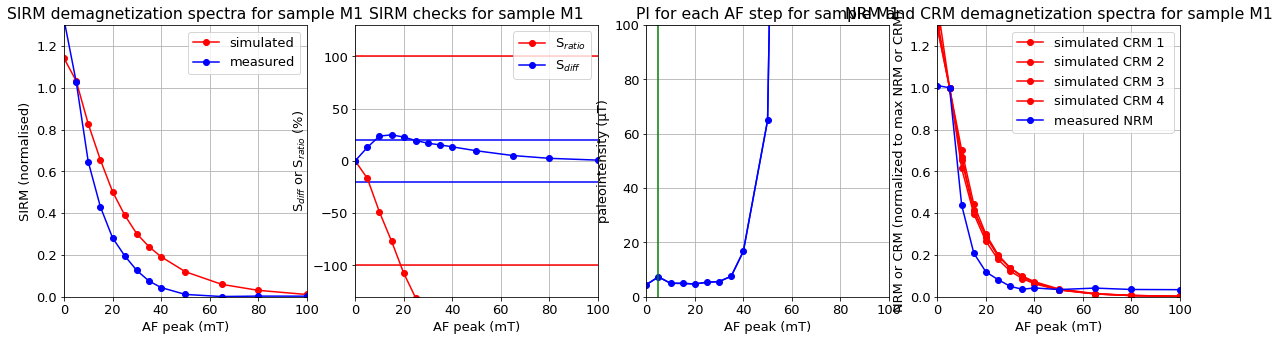

Pick the AF step for the lower bound of the platau palaeointensity region to calcualte the median palaeointensity from:10
Pick the AF step for the upper bound of the platau palaeointensity region to calcualte the median palaeointensity from:30


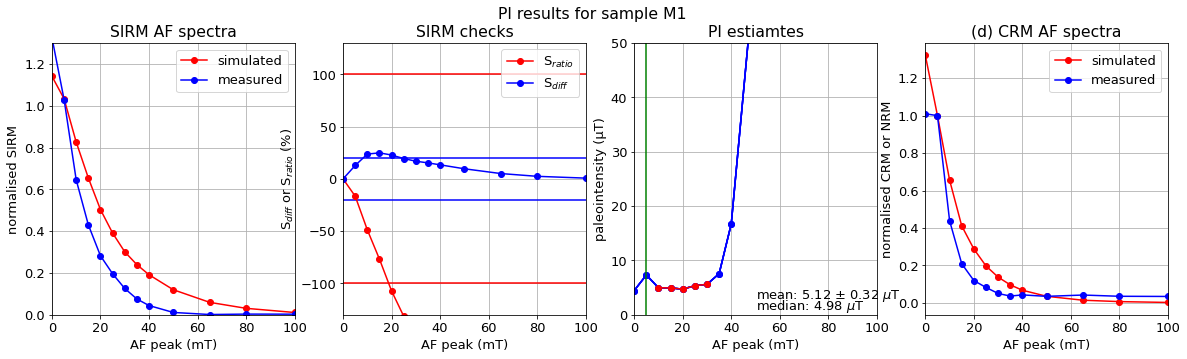

In [12]:
X, V = calc_PI_checks_SIRM(V,X)
fin_pal_SIRM(X,V)

In [ ]:
print(np.max(V['prop'][:,2]))

In [ ]:
X, V = pf.calc_PI_checks_SIRM(V,X)
pf.fin_pal_SIRM(X,V)

In [ ]:
#arm file function
import numpy as np
def plot_file_arm(V,X):
    arm_int = np.copy(V['arm']) # gives me the maximum value
    crm_int = np.copy(V['afmag']) # first af demag step for crm i think - check it from 
    sirm_int = np.copy(V['sirm']) # first af demag step for crm i think - check it from 
    #hysteron_list_copy = np.copy(V['hysteron_list'])
    #arm_acq_steps_list_copy = np.copy(V['arm_acq_steps_list'])
    #plt.scatter(arm_acq_steps_list_copy, arm_int[:len(arm_acq_steps_list_copy)])
    #plt.xlabel('number arm acq steps')
    #plt.ylabel('max ARM intensity')
    #plt.title('max ARM intensity vs number arm acq steps')
    #plt.savefig('arm_steps_vs_arm.png')
    #plt.close()
    
    for i in range(3):
        field = (V['fields']*(4*np.pi*1E-7)/1E-6)
        arm_file = open("steps_arm_crm_sirm_{}_{:.1f}.txt".format(X['name'], field[i]), "w") #'w' will overwrite file is already exists
        arm_file.write('arm_steps' + '\t' + 'arm_intensity' + '\t' + 'crm intensity' + '\t' + 'sirm intensity' + '\n') 
        for write_list in range(len(X['af_step'])):
            arm_file.write(str(X['af_step'][write_list]) + '\t' + str(arm_int[i][write_list]) + '\t' + str(crm_int[i][write_list]) + '\t' + str(sirm_int[i][write_list]) + '\n')
        arm_file.close()

In [ ]:
print((V['fields']*(4*np.pi*1E-7)/1E-6))

In [ ]:
plot_file_arm(V,X)

In [ ]:
import matplotlib.pyplot as plt
def plot_graph_crm_sirm(V,X):
    crm_int = np.copy(V['afmag']) # first af demag step for crm i think - check it from 
    sirm_int = np.copy(V['sirm']) # first af demag step for crm i think - check it from 
    for i in range(3):
        field = (V['fields']*(4*np.pi*1E-7)/1E-6)
        plt.plot(X['af_step'][:], crm_int[i][:]/sirm_int[i][:], '-o')
        plt.title('{} AF demag Field = {:.2f}'.format(X['name'], field[i]))
        plt.xlabel('AF step (mT)')
        plt.ylabel('CRM/SIRM')
        plt.savefig('CRM_SIRM_AF_{}_{}.pdf'.format(X['name'], field[i]))
        plt.close()

In [ ]:
plot_graph_crm_sirm(V,X)

In [ ]:
def plot_crm_sirm_nrm_sirm(V,X):
    crm_int = np.copy(V['afmag']) # first af demag step for crm i think - check it from 
    sirm_int = np.copy(V['sirm']) # first af demag step for crm i think - check it from 
    #measured values 
    sirm_mea = X['af_sirm']
    nrm_mea = X['af_nrm']
    for i in range(4):
        field = (V['fields']*(4*np.pi*1E-7)/1E-6)
        plt.plot(X['af_step'][:], crm_int[i][:]/sirm_int[i][:], '-o', label = 'sim {}'.format(field[i]))
    plt.plot(X['af_step'][:], nrm_mea[:]/sirm_mea[:], label = 'meas 75 muT')
    plt.title('{} AF demag Field = {:.2f}'.format(X['name'], field[i]))
    plt.xlabel('AF step (mT)')
    plt.ylabel('CRM/SIRM')
    plt.legend()
    plt.savefig('CRM_SIRM_NRM_SIRM_AF_{}.pdf'.format(X['name']))
    plt.close()

In [ ]:
plot_crm_sirm_nrm_sirm(V,X)

In [ ]:
import numpy as np
arm_int = np.copy(V['arm'][:,0]) # gives me the maximum value
crm_int = np.copy(V['afmag'][:,0]) # first af demag step for crm i think - check it from 
arm_file = open("growth_rate_vs_arm_{}.txt".format(X['names'][0]), "w") #'w' will overwrite file is already exists
arm_file.write('growth rate' + '\t' + 'arm_intensity' + '\t' + 'crm intensity' + '\n') 
growth_rate_list_copy = np.copy(V['growth_rate_list'])
for write_list in range(len(growth_rate_list_copy)):
    arm_file.write(str(growth_rate_list_copy[write_list]) + '\t' + str(arm_int[write_list]) + '\t' + str(crm_int[write_list]) + '\n')
arm_file.close()


In [ ]:
#demag lists
arm_int = np.copy(V['arm']) # gives me the maximum value
crm_int = np.copy(V['afmag']) # first af demag step for crm i think - check it from 
af_steps_print = np.copy(V['af_step'])
growth_rate_list_copy = np.copy(V['growth_rate_list'])

for num_rates in range(len(growth_rate_list_copy)):
    af_file = open("demag_crm_arm_{}_{}.txt".format(X['names'][0], V['growth_rate_list'][num_rates]), "w")
    af_file.write('AF' + '\t' + 'crm' + '\t' + 'arm' + '\n') 

    for write_list2 in range(len(af_steps_print)):
        af_file.write(str(af_steps_print[write_list2]) + '\t' + str(crm_int[num_rates][write_list2]) + '\t' + str(sirm_int[num_rates][write_list2]) + '\n')
    af_file.close()

In [ ]:
print(np.max(V['hys'][:,0]))
print(np.max(V['hys'][:,1]))

In [ ]:
from matplotlib import pyplot as plt
plt.hexbin(V['hys'][:,0], V['hys'][:,1])
plt.colorbar()

In [ ]:
pf.plot_file_arm(V)

In [ ]:
from matplotlib import pyplot as plt
plt.tricontourf(V['hys'][:,0], V['hys'][:,1], V['boltz'][:], levels=np.linspace(-1.1,1.1,100))
plt.colorbar()
plt.xlim(0,80000)
plt.title('Preisach space hc, hi, boltz arm 0 dc acq step {}'.format(V['afstore']))
plt.ylabel('hi')
plt.xlabel('hc')
plt.savefig('preisach_arm_acq_boltz_0dc_{}.png'.format(V['afstore']))
#plt.close() 
plt.show()   

In [ ]:
print(V['afmag'])
print(V['arm'])
print(V['sirm'])

In [ ]:
print(V['arm'])

The model has calcualted a paleointesnity for each AF step, the left hand figures are the SIRM checks and where the SIRM checks are out of bounds the palaeoitensity is not reliable, marked by above the respective straight lines. Pick the flat region on the right hand graph where these checks are also accepted. the green line highlights where the rimary componant begind. 

The palaeointensity estiamte for this run of the sample will be appended to the results files paleo_results.dat. The figure below with the estiamtes and checks will be saved as PI_restults_samplename.svg inside the folder sample_samplename_V_samplerun. The raw data will be saved in the files inside a folder dedicated to this run of this specific sample full_data_sample_samplename_run_samplerun.dat inside sample_samplename_V_samplerun. 

In [ ]:
X, V = pf.calc_PI_checks_SIRM(V,X)
pf.fin_pal_SIRM(X,V)

In [ ]:
print(V['ys'])

In [ ]:
print()

In [ ]:
print(V['afmag']/V['sirm'])

In [ ]:
print(X[])

In [ ]:
print(X['af_arm'])
print(V['fields'])
print(V['afmag'])
print(V['arm'])

In [ ]:
list(X['af_irm'])

In [ ]:
X.clear()
V.clear()